In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [2]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16;


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector}}, Tuple{ODEProblem, Real, Union{Nothing, Vector}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


In [26]:
### PARAMETERS ###################################
# csv file to load the initial solution
# indices of the best (min TOF) solutions
# maxJC2 : # 327
# velThrust : # 835
# EMrot : #394
# Tidal : #31


# ig_file  = "../run/data/diffcorr_0717_TidalThrust.csv"
# opt_file = "../run/data/opt_0717_EMrotThrust.csv"
# dir_func = SailorMoon.dv_tidal_dir_sb1frame
# solid = 1


# ig_file  = "../run/data/diffcorr_0618_velThrust.csv"
# opt_file = "../run/data/opt_0618_velThrust.csv"
# dir_func = SailorMoon.dv_vel_dir_sb1frame
# solid = 835


# ig_file  = "../run/data/diffcorr_0618_maxJCThrust2.csv"
# opt_file = "../run/data/opt_0618_maxJCThrust.csv"
# dir_func = SailorMoon.dv_maxJC_dir_sb1frame
# solid = 327

ig_file  = "../run/data/diffcorr_0717_EMrotThrust_10.csv"
opt_file = "../run/data/opt_0717_EMrotThrust_10.csv"
dir_func = SailorMoon.dv_EMrotdir_sb1frame
solid  = 394


n_arc = 10


# load initial guess
df_ig  = CSV.read(ig_file, DataFrame; header=0);
df_opt = CSV.read(opt_file, DataFrame; header=0);


### plot the optimized trajectory

In [27]:
# position = indexin( solid, df_opt[:,1] )
position = findall( x -> x == solid, df_opt[:,1])
println(position)
row_opt = df_opt[position[2],:]

x = Float64.(collect(row_opt[4:end]))

t_, u_, th_, th_nominal  = SailorMoon.x2time_series(x, dir_func, paramMulti, true);
u_array = [u_[:,i] for i in collect(1:size(u_,2))]

θm_lpo = x[19+12*paramMulti.n_arc]  
# thrust_param_nomi = [1.0, 0.0, 0.0]
# th_nominal = get_thrust(t_, u_array, thrust_param_nomi, θm_lpo, dir_func)
# th_nominal = hcat(th_nominal...)


[1, 2]


3.322140381063897

In [28]:
_, sol_list, _, tofs = SailorMoon.multishoot_trajectory2(x, dir_func, paramMulti, true, false, true)
sol, _, _  = sol_list[1]
m_leo = sol[end, end]
println("m_leo; ", round(m_leo, digits=4))

# fitness!, ng, lg, ug, eval_sft = SailorMoon.get_fitness5_minToF_fixmleo(dir_func, paramMulti, x0, m_leo, true)
fitness!, ng, lg, ug, eval_sft = SailorMoon.get_fitness4_minmleo_fixToF(dir_func, paramMulti, x, sum(tofs), true)

# checking if the initial guess is good enough
res = eval_sft(x)

m_leo; 1.0182


13-element Vector{Float64}:
 -1.475640692660818e-6
  1.3063336294472095e-6
  8.072533646708013e-7
 -3.5749046852218137e-7
  1.299447216496219e-10
 -7.277065430244534e-6
 -1.9114759432503625e-6
  1.797278601500807e-7
 -8.121485092438263e-6
 -5.533564717552508e-10
  0.000970937759812943
  2.0014371441973155e-7
  0.0

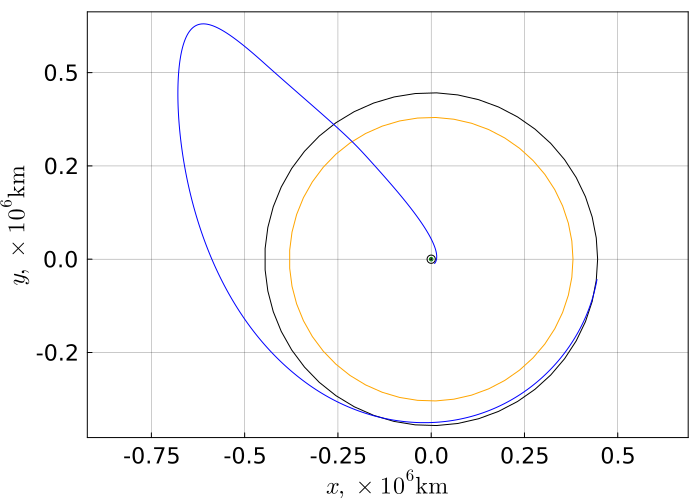

In [21]:
# moon     = SailorMoon.plot_circle(1-param3b.mu2, param3b.as , 0.0)
# earth    = SailorMoon.plot_circle(param3b.mu2, param3b.as, 0.0)
# earth_ub = SailorMoon.plot_circle(param3b.mu2+6375/param3b.lstar, param3b.as, 0.0)
# earth_lb = SailorMoon.plot_circle(param3b.mu2-6375/param3b.lstar, param3b.as, 0.0)
# moon_soi_outer = SailorMoon.plot_circle(1-param3b.mu2+66000/param3b.lstar, param3b.as, 0.0);


moon     = SailorMoon.plot_circle((1-param3b.mu2)*param3b.lstar, 0.0, 0.0)
earth    = SailorMoon.plot_circle(param3b.mu2*param3b.lstar, 0.0, 0.0)
earth_ub = SailorMoon.plot_circle(param3b.mu2*param3b.lstar+6375,0.0, 0.0)
earth_lb = SailorMoon.plot_circle(param3b.mu2*param3b.lstar-6375, 0.0, 0.0)
moon_soi_outer = SailorMoon.plot_circle((1-param3b.mu2)*param3b.lstar+66000, 0.0, 0.0);

p = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false, 
    xlabel=L"x, \times10^6\textrm{km}", ylabel=L"y, \times10^6\textrm{km}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

plot!(p, earth[1,:], earth[2,:], c=:green, lw=1.0, label="")
plot!(p, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="")
plot!(p, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="")
plot!(p, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="")
plot!(p, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6, digits=1))),
)
plot!(p,(u_[1,:].-param3b.as).*param3b.lstar, u_[2,:].*param3b.lstar, c=:blue, label="optim. traj.")


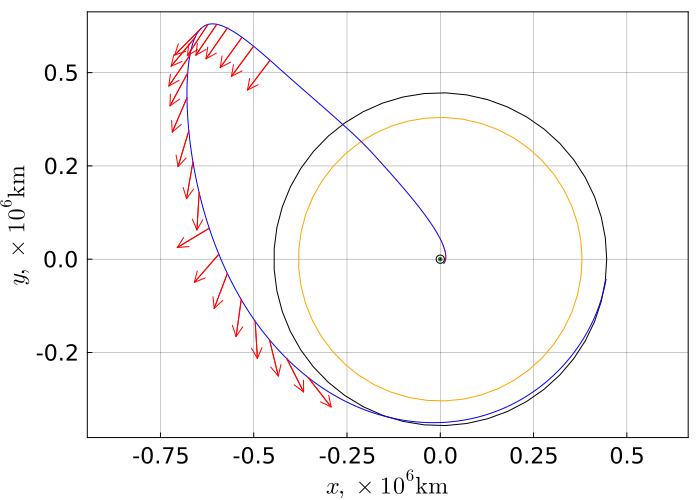

In [22]:
k = size(u_,2)
m = 20
l = 1e5
quiver!(p,(u_[1,collect(1:m:k)].-param3b.as).*param3b.lstar, u_[2,collect(1:m:k)].*param3b.lstar, 
    quiver=(th_[1,collect(1:m:k)]*l, th_[2,collect(1:m:k)]*l), c=:red, label="")

### Now put the initial guess (diff-corr) trajectory 

In [23]:
position = indexin( solid, df_ig[:,1] )
row_ig = df_ig[position[end],:]
x = Float64.(collect(row_ig[4:end]))
t_ig, u_ig, th_ig, th0_ig  = SailorMoon.x2time_series(x, dir_func, paramMulti, false);
t_days = t_ * param3b.tstar / 86400
t_days = t_days .- t_days[end]  # scale it back to days, and set t_LEO = 0 


1356-element Vector{Float64}:
 49.83591357226643
 49.827761189512955
 49.81174919416284
 49.79314176292648
 49.7699229150105
 49.74354109075059
 49.71360216419332
 49.68101744131944
 49.64575538293762
 49.60835314804005
 49.56905491718057
 49.52819735137956
 49.48604949488646
  ⋮
  0.0019296922649800763
  0.001739344063643955
  0.001548839360637544
  0.001358557478859268
  0.0011687267631046439
  0.0009790285591435577
  0.0007891791193159747
  0.0005984236820921751
  0.000408828750352086
  0.00021841505773068093
  2.9059067834680263e-5
  0.0

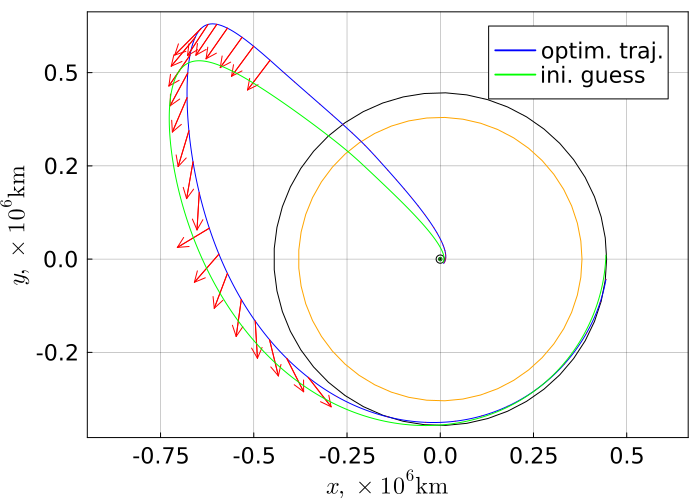

In [24]:
plot!(p,(u_ig[1,:].-param3b.as)*param3b.lstar, u_ig[2,:].*param3b.lstar, c=:lime, label="ini. guess")
plot!(p, legend=:topright)
# plot!(p, xlim=[-0.7e6, 1.3e6])

### thrust history

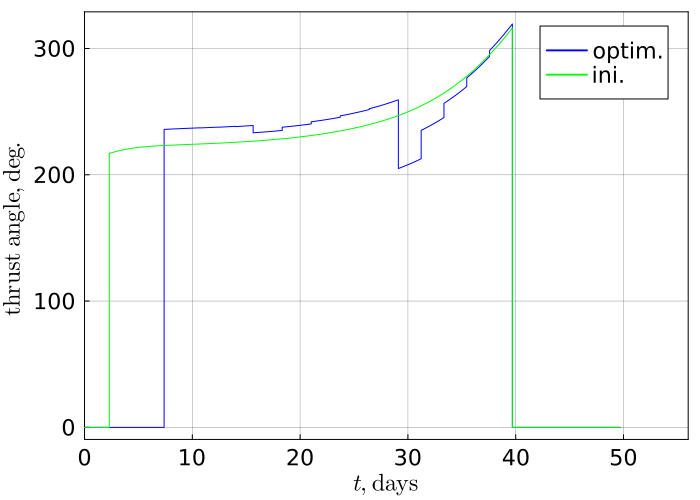

In [20]:
p_thrust = plot(
    size=(700,500), frame_style=:box, grid=0.4, legend=false, 
    xlim = [0, 56],
    xlabel=L"t, \textrm{days}", 
    ylabel=L"\textrm{thrust} \ \textrm{angle, deg.}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

angd = atan.(th_[2,:], th_[1,:])
val = [mod2pi(el)/pi*180 for el in angd]


plot!(p_thrust, t_days, val, c=:blue, label="optim.")

angd = atan.(th_nominal[2,:], th_nominal[1,:])
val = [mod2pi(el)/pi*180 for el in angd]

plot!(p_thrust, t_days, val, c=:lime, label="ini.")

plot!(p_thrust, legend=:topright)

### save

In [20]:
savefig(p, "optim_traj_tidalThrust.png")
savefig(p_thrust, "optim_thrust_tidalThrust.png")

"C:\\Users\\yujit\\Documents\\github\\SailorMoon.jl\\tests_yuji\\optim_thrust_tidalThrust.png"